# Customer Segmentation Report

In [1]:
%matplotlib inline
import pickle
import itertools
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

c:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Data

In [2]:
# load the local dataset 
df = pd.read_csv('../data/bank_customer_dataset.csv')

df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# Load Model Artifacts

In [3]:
with open('../artifacts/numeric_imputer.pickle', 'rb') as filename: # trained model to impute missing numeric data
    numeric_imputer = pickle.load(filename)

with open('../artifacts/capper.pickle', 'rb') as filename: # trained model to cap outliers
    capper = pickle.load(filename)   

with open('../artifacts/model.pickle', 'rb') as filename: # trained random forrest classifier
    model = pickle.load(filename)

# Transform Dataset

In [4]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = df.select_dtypes(include=numerics).columns.to_list()

In [5]:
# impute mising numeric features
df_numeric = pd.DataFrame(
    numeric_imputer.transform(df[numeric_columns]), 
    columns=numeric_columns, 
    index=df.index)

# remove outliers
df_numeric = capper.transform(df_numeric)

# predict cluster
labels = model.predict(df_numeric)

# add cluster label to df
df['cluster'] = labels

df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,1
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,0
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,1


# Data Visualization

In [6]:
# Cluster Counts
df['cluster'].value_counts()

0    6594
1    1816
2     540
Name: cluster, dtype: int64

## What does the Cluster Distribution Lool Like?

In [7]:
# Cluster Counts
cluster_labels = []
for c in df['cluster'].value_counts().index.tolist():
    if c == 0:
        label = 'Noise Cluster'
    else:
        label = 'Cluster ' + str(c)
    cluster_labels.append(label)

cluster_labels

['Noise Cluster', 'Cluster 1', 'Cluster 2']

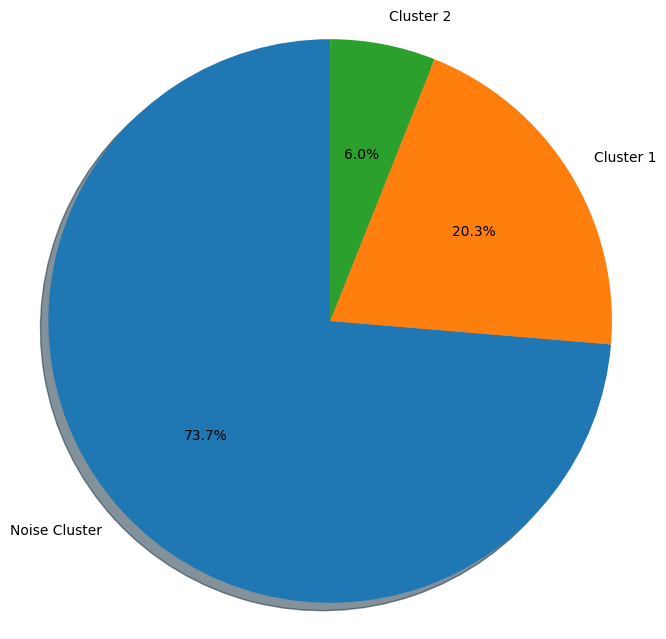

In [8]:
labels = cluster_labels
sizes = df['cluster'].value_counts().to_list()
explode = (0, 0, 0)  

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(
    x=sizes, 
    explode=explode, 
    labels=labels, 
    autopct='%1.1f%%',
    shadow=True, 
    startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Determine Cluster Centers

In [9]:
# Cluster Centers
df.groupby(by='cluster').median()

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,937.806150,1.0,582.895,178.815,163.48,0.000000,0.583333,0.1,0.333333,0.000000,0.0,9.0,4000.0,1232.78107,357.086194,0.000000,12.0
1,958.125169,1.0,0.000,0.000,0.00,96.134078,0.000000,0.0,0.000000,0.083333,1.0,0.0,1950.0,442.85716,315.054229,0.000000,12.0
2,73.222225,1.0,431.965,0.000,419.94,0.000000,1.000000,0.0,1.000000,0.000000,0.0,12.0,2000.0,408.75430,174.121900,0.166667,12.0


# Explain Clusters

In [10]:
# Tree Explainer
explainer = shap.TreeExplainer(
    model = model.best_estimator_,
    output = 'probability')

# get random sample
X = df.iloc[:,1:-1].sample(1000)

# calculate shap values
shap_values = explainer.shap_values(X)

# Custom Functions

In [11]:
def get_top_cluster_features(shap_values, cluster=0, topn=5):
    """Get top n features for given cluster"""
    shap_values_df = pd.DataFrame(
        data=shap_values[cluster],
        columns=X.columns
    )

    shap_values_df_topn = shap_values_df.abs().mean().sort_values(ascending=True)[-topn:]
    topn_features = shap_values_df_topn.index[::-1].to_list()
    return topn_features

def plot_cluster_feature_importance(shap_values, cluster=0, topn=5):
    """Barplot feature importance for specific cluster"""
    fig = plt.figure(figsize=(10,6))
    shap_values_df = pd.DataFrame(
        data=shap_values[cluster],
        columns=X.columns
    )

    shap_values_df_topn = shap_values_df.abs().mean().sort_values(ascending=True)[-topn:]
    topn_features = shap_values_df_topn.index[::-1].to_list()

    # get most important top n
    plt.barh(
        width=shap_values_df_topn, 
        y=shap_values_df_topn.index
    )
    plt.title('Feature Importance for Cluster {}'.format(cluster))
    plt.xlabel('mean(|shap value|)')
    #plt.xlim(-.1,.4)
    plt.show()

def plot_cluster_shap_values(shap_values, cluster=0, topn=5):
    """Violin plot of the shap values for cluster"""
    shap.summary_plot(
        shap_values = shap_values[cluster], 
        features = X,
        sort=True,
        plot_size=(12.0,6.0),
        show=False,
        max_display=topn,
        plot_type='violin'
        )
    ax=plt.gca()
    ax.set_title('Shap Feature Importance for Cluster {}'.format(cluster))
    ax.grid()
    ax.set_xlim(-.4,.4)
    fig = plt.gcf()
    plt.show()

def jitter(values, loc, scale):
    """Add some jitter for visibility"""
    return values + np.random.normal(loc, scale,values.shape)

## Average Feature Importance on Cluster Building

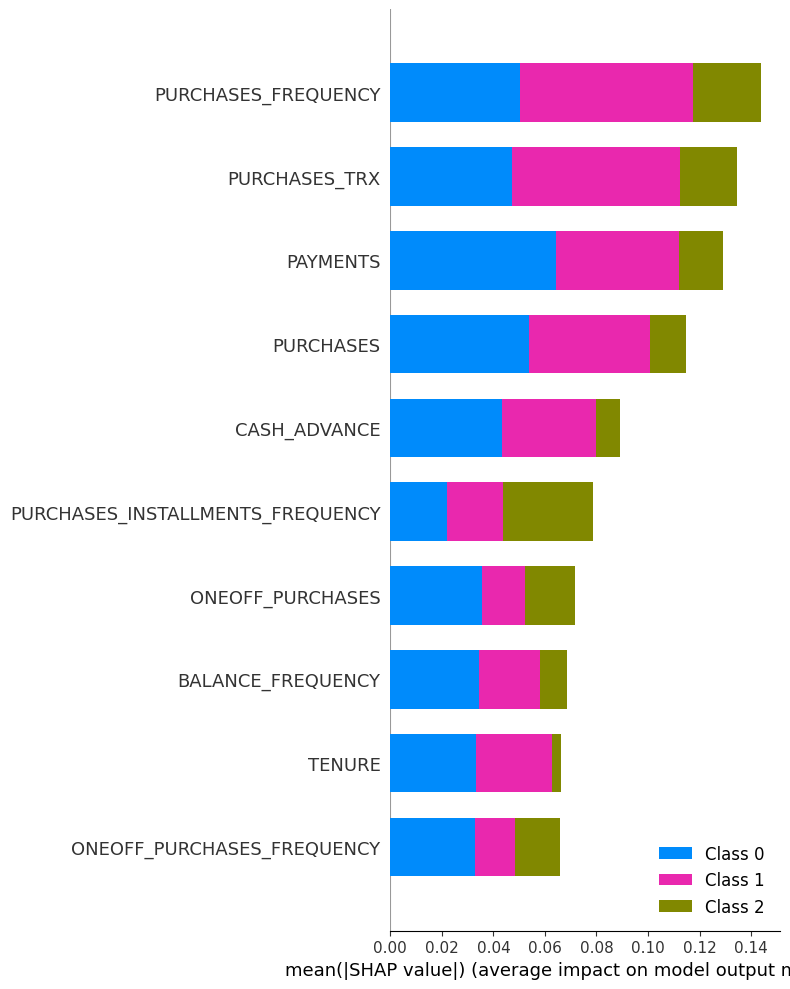

In [12]:
shap.summary_plot(
    shap_values = shap_values, 
    features = X,
    sort=True,
    max_display=10,
    plot_size=(8.0,10.0)
)

## Explain Single Cluster vs Rest

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


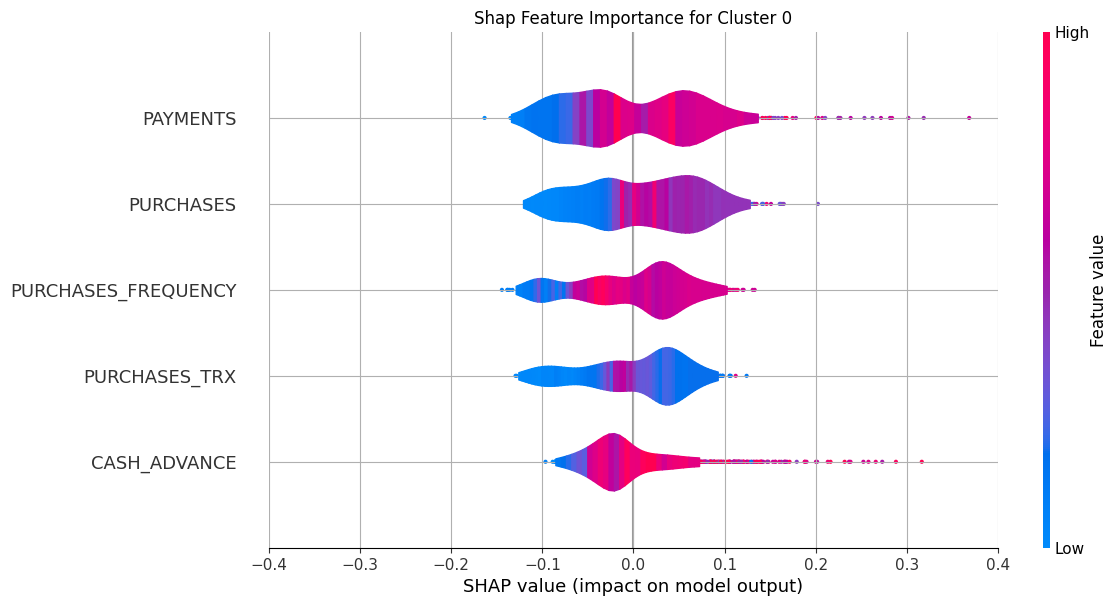

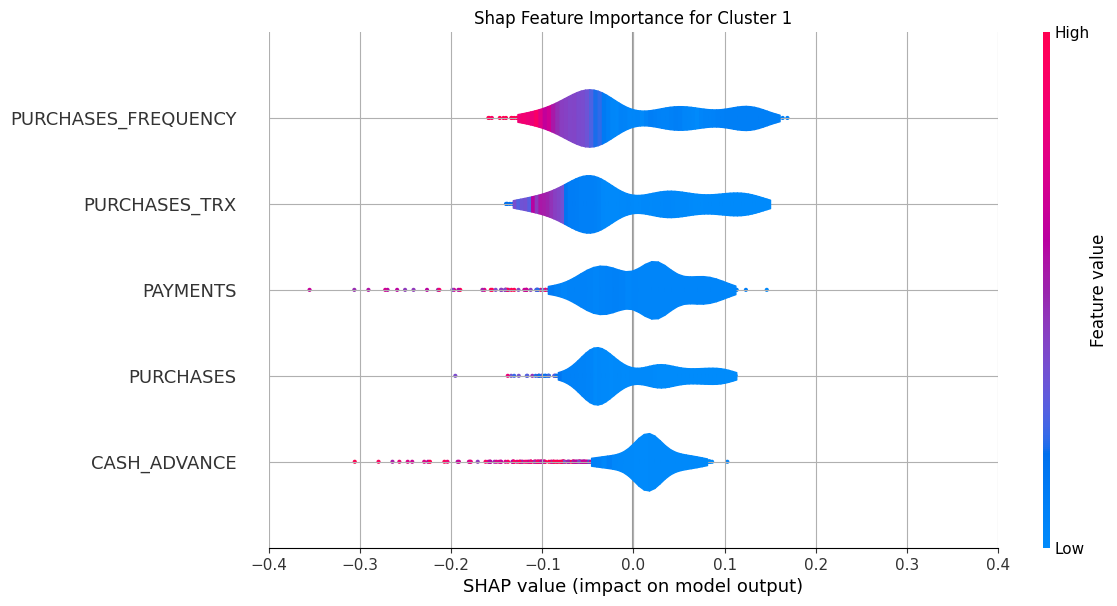

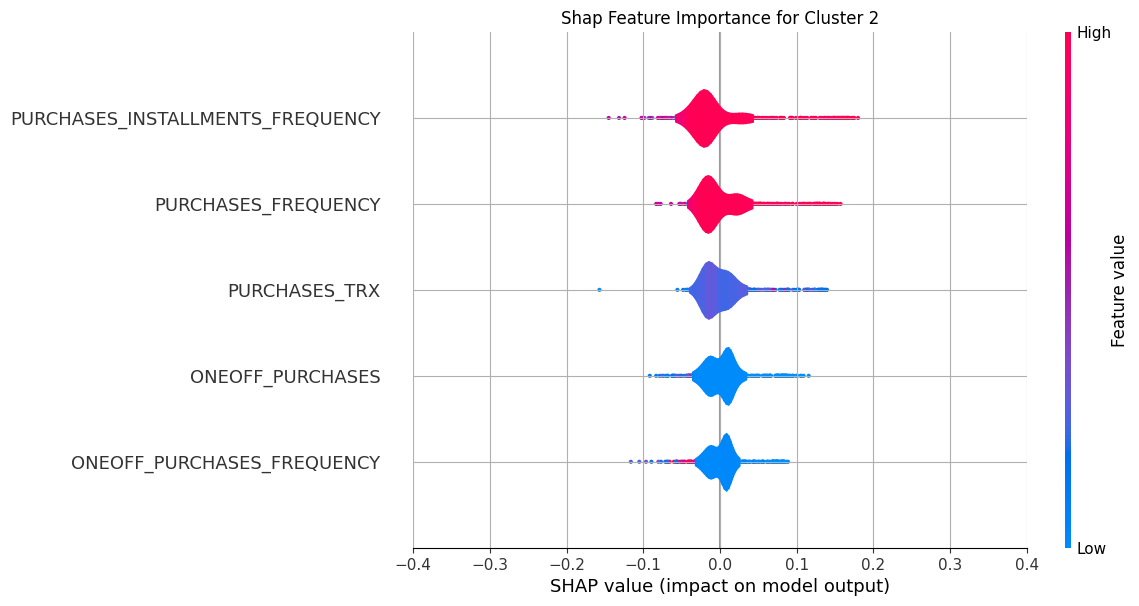

In [13]:
for c in np.sort(df['cluster'].unique()):
    #plot_cluster_feature_importance(
    #    shap_values, 
    #    cluster=c, 
    #    topn=5)
    
    plot_cluster_shap_values(
        shap_values, 
        cluster=c, 
        topn=5)

In [14]:
# get most important features considering the top n features in each cluster
n=5 
array = [get_top_cluster_features(shap_values, cluster=c, topn=n) for c in np.sort(df['cluster'].unique())]
top_features = list(set(chain(*array)))
top_features

['PAYMENTS',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'PURCHASES_TRX',
 'ONEOFF_PURCHASES',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES_FREQUENCY']

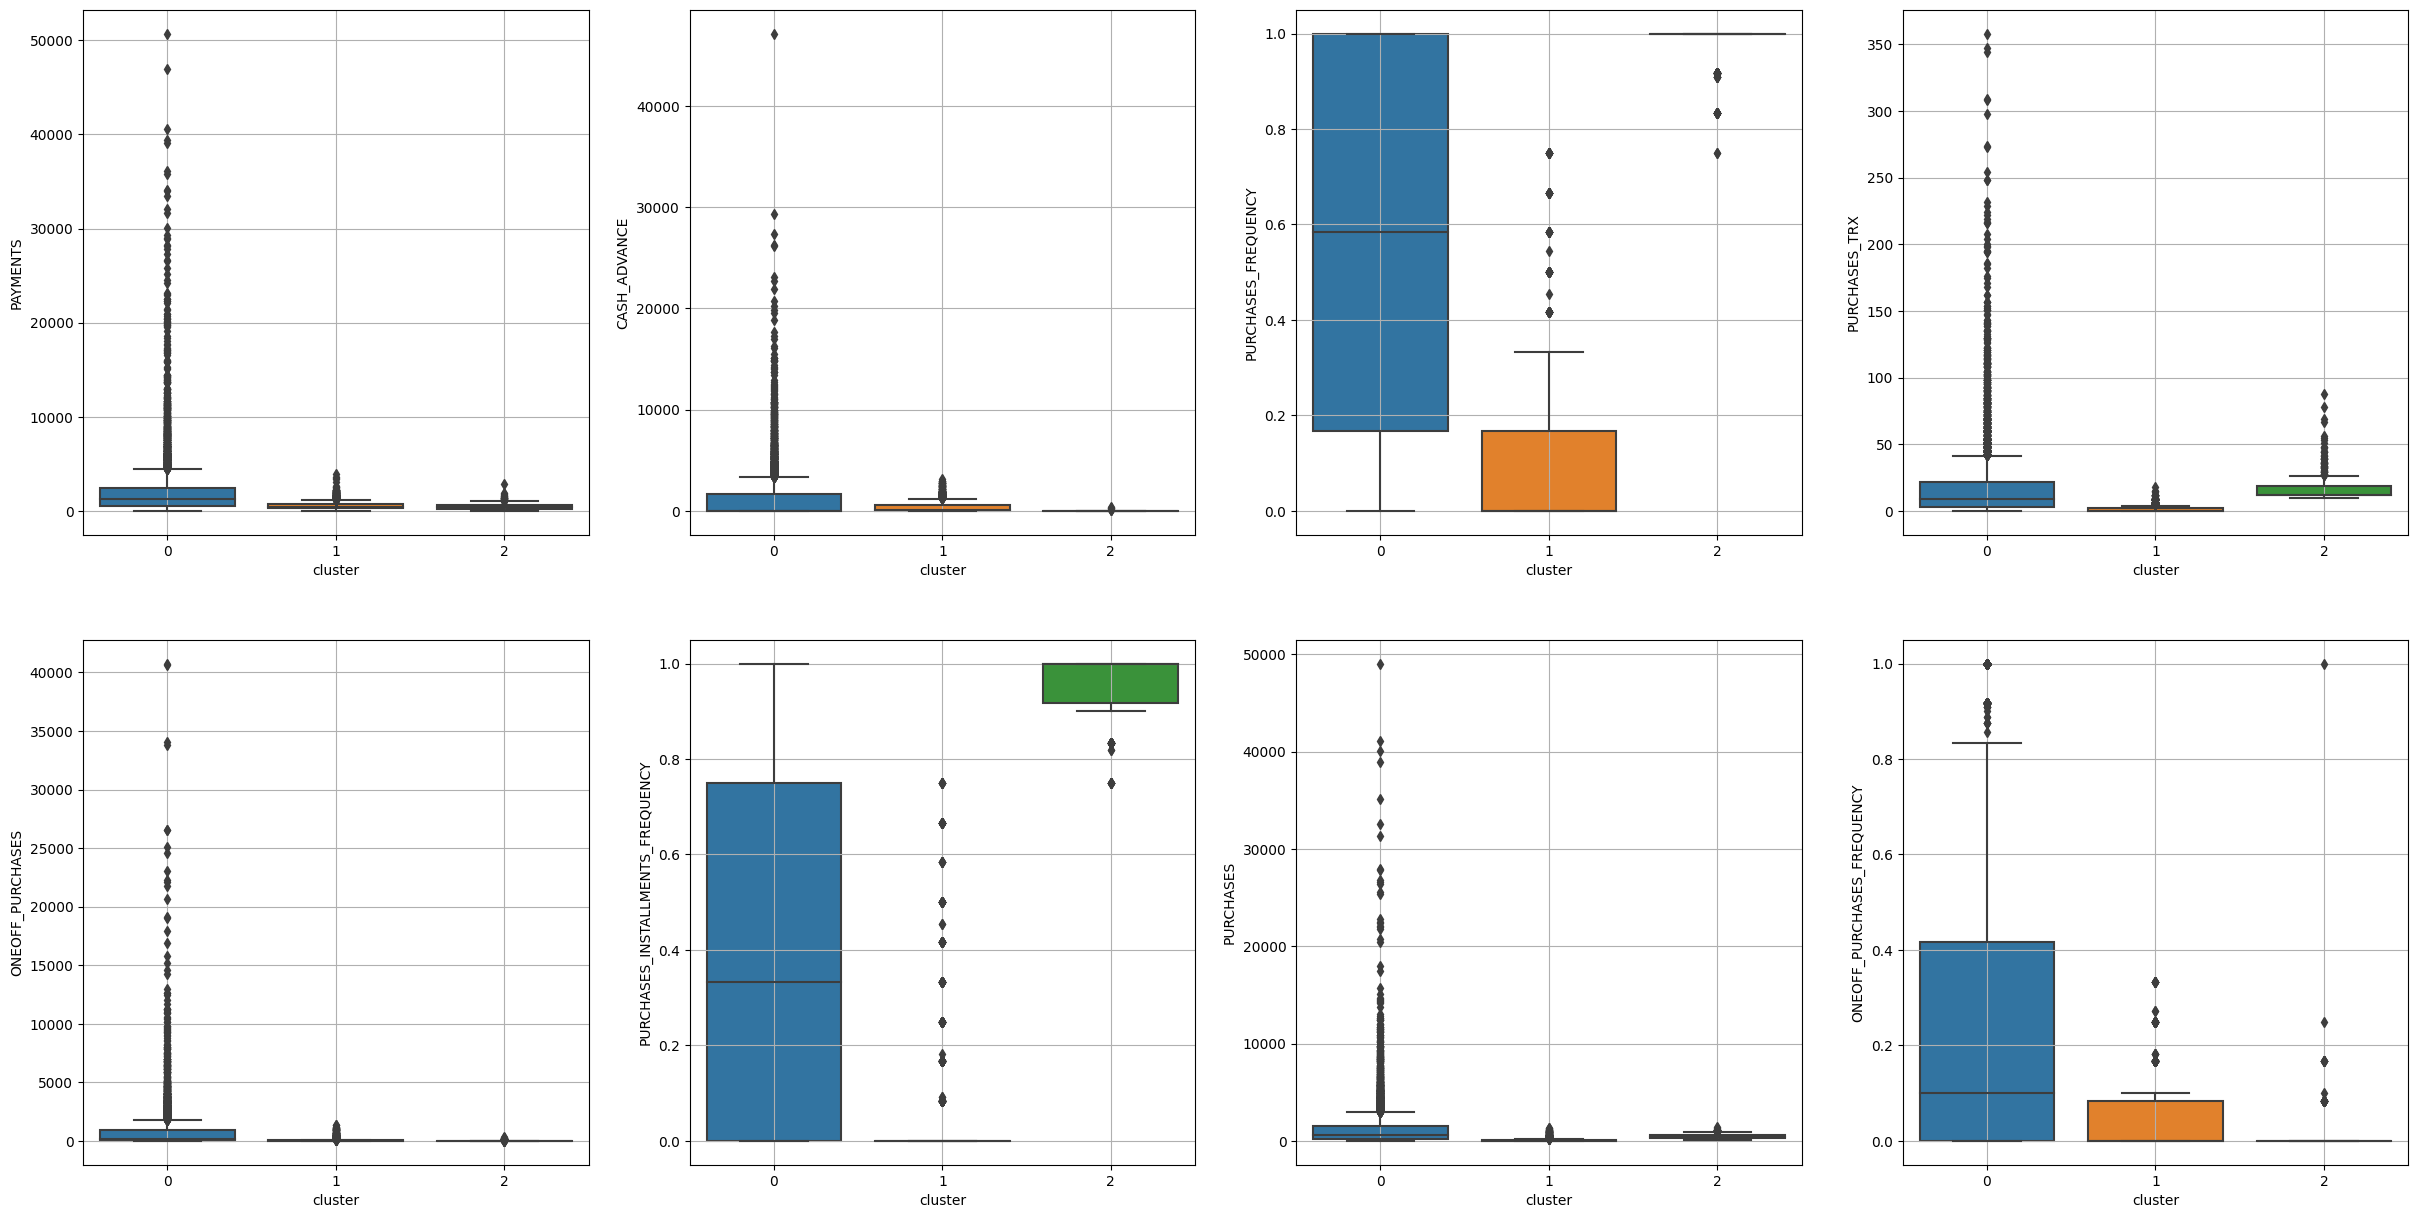

In [15]:
# boxplots for numeric columns
fig, ax = plt.subplots(
        figsize=(30,15), 
        nrows=2, 
        ncols=4, 
        #sharex=True
        )
ax = ax.flatten()


for n, feat in enumerate(top_features):
    sns.boxplot(
        data=df,
        x='cluster',
        y=feat,
        whis=1.0,
        ax=ax[n]
    )
    ax[n].grid()
plt.show()

In [16]:
# show number of unique combinations for scatter plotting
len([c for c in itertools.combinations(top_features, 2)])

28

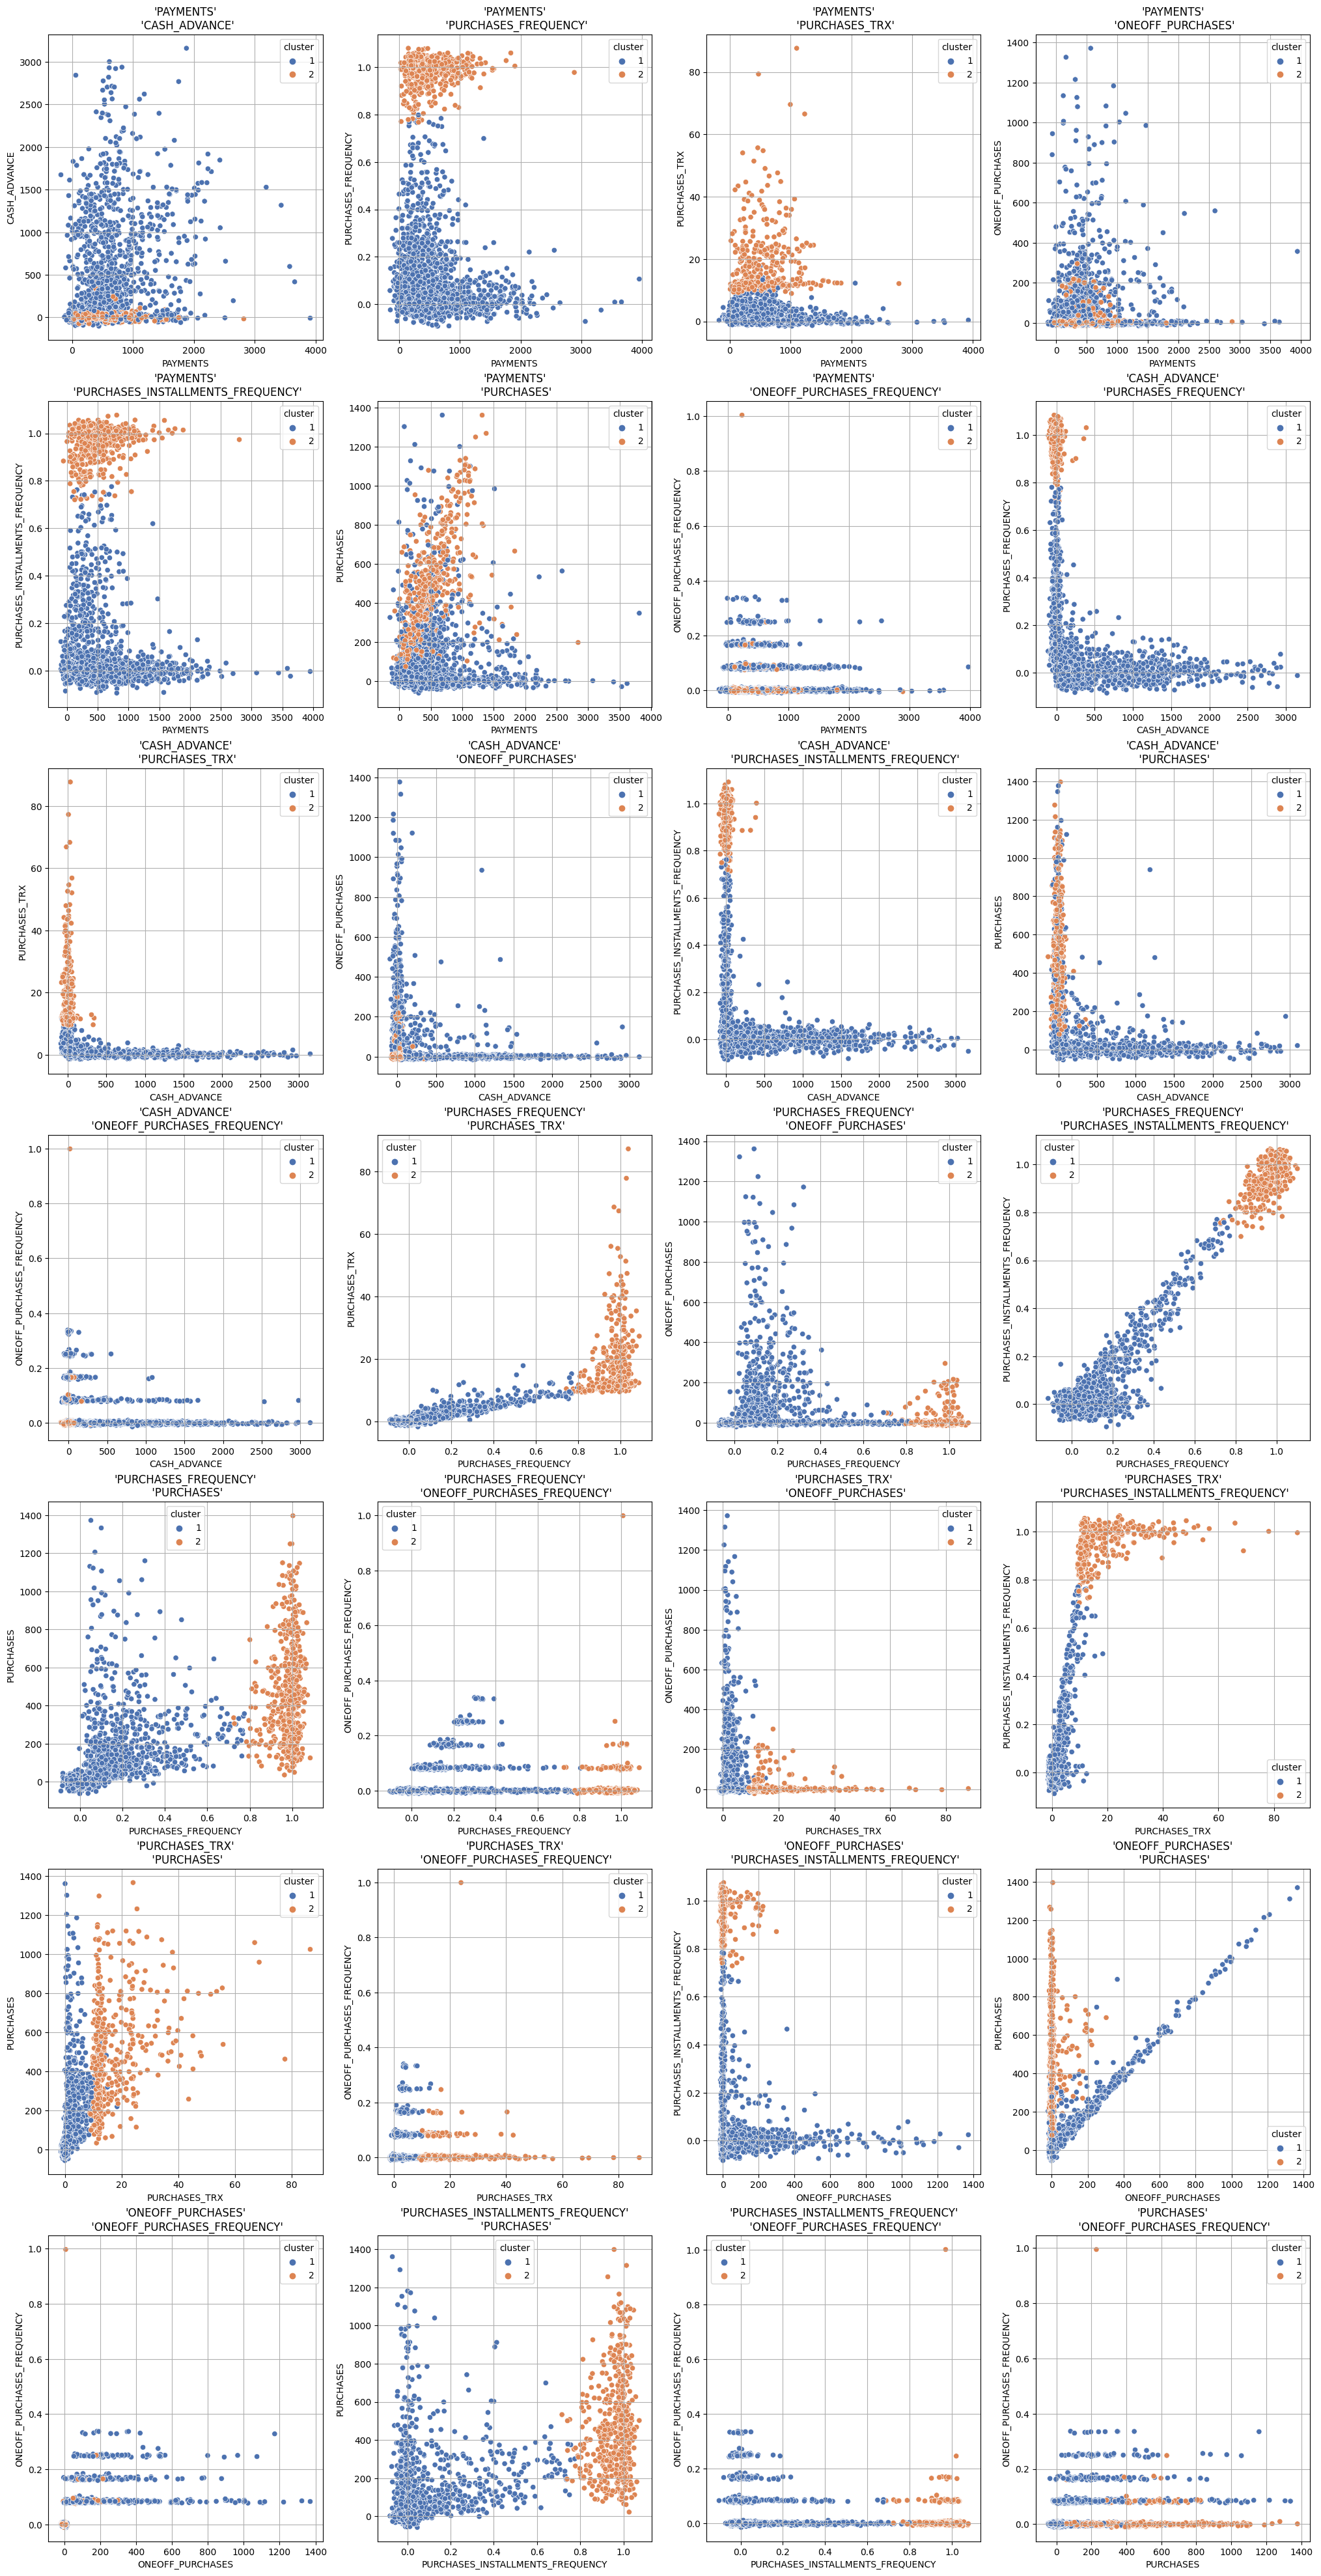

In [17]:
# exclude noise for visibility
data = df[df['cluster']!=0]
#size=[1 if c == 0 else 2 for c in df['cluster']]

fig, ax = plt.subplots(
        figsize=(25,50), 
        nrows=7, 
        ncols=4, 
        #sharex=True
        )
ax = ax.flatten()

for n, c in enumerate(itertools.combinations(top_features, 2)):
    x = data[c[0]]
    x_mean = np.mean(x)
    y = data[c[1]]
    y_mean = np.mean(y)

    sns.scatterplot(
        data=data,
        x=jitter(x, 0, 0.1*x_mean),
        y=jitter(y, 0, 0.1*y_mean),
        hue='cluster',
        #hue_order=(1,2,0),
        palette='deep',
        #alpha=.5,
        #size=size,
        ax=ax[n]
    )
    title = str(c).strip('(,)').split(',')
    ax[n].set_title(title[0]+'\n'+title[1])
    ax[n].grid()


In [18]:
# Export Notebook as PDF
#!jupyter nbconvert  --output-dir='../reports' --to pdf --no-input 03_customer_seg_bankdata_report.ipynb

C:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\traitlets\traitlets.py:2544: FutureWarning: Supporting extra quotes around strings is deprecated in traitlets 5.0. You can use '../reports' instead of "'../reports'" if you require traitlets >=5.
  warn(
[NbConvertApp] Converting notebook 03_customer_seg_bankdata_report.ipynb to pdf
[NbConvertApp] Support files will be in 03_customer_seg_bankdata_report_files\
[NbConvertApp] Making directory .\03_customer_seg_bankdata_report_files
[NbConvertApp] Making directory .\03_customer_seg_bankdata_report_files
[NbConvertApp] Making directory .\03_customer_seg_bankdata_report_files
[NbConvertApp] Making directory .\03_customer_seg_bankdata_report_files
[NbConvertApp] Making directory .\03_customer_seg_bankdata_report_files
[NbConvertApp] Making directory .\03_customer_seg_bankdata_report_files
[NbConvertApp] Making directory .\03_customer_seg_bankdata_report_files
[NbConvertApp] Writing 35666 bytes to notebook.tex
[NbConvertApp